In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import os
import gc
from tqdm import tqdm
import random

import warnings
warnings.filterwarnings('ignore')

def seed_all(SEED=42):
    np.random.seed(SEED)
    os.environ['PYTHONHASHSEED']=str(SEED)
    random.seed(SEED)
    tf.random.set_seed(SEED)

In [2]:
data = pd.read_csv('./data/train/train.csv')
valid_cols = ['DHI', 'DNI', 'T', 'TARGET'] # WS RH
data

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0,0,0,0,1.5,69.08,-12,0.0
1,0,0,30,0,0,1.5,69.06,-12,0.0
2,0,1,0,0,0,1.6,71.78,-12,0.0
3,0,1,30,0,0,1.6,71.75,-12,0.0
4,0,2,0,0,0,1.6,75.20,-12,0.0
...,...,...,...,...,...,...,...,...,...
52555,1094,21,30,0,0,2.4,70.70,-4,0.0
52556,1094,22,0,0,0,2.4,66.79,-4,0.0
52557,1094,22,30,0,0,2.2,66.78,-4,0.0
52558,1094,23,0,0,0,2.1,67.72,-4,0.0


In [3]:
zero_hour = []
for i in range(24):
    if data[data['Hour']==i].sum()['TARGET'] == 0:
        zero_hour.append(i)
zero_hour

[0, 1, 2, 3, 4, 20, 21, 22, 23]

In [4]:
train = data[valid_cols].copy()
target = data['TARGET'].copy()

In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# sc = StandardScaler()
tr_sc  = MinMaxScaler()
tar_sc = MinMaxScaler()
tr_sc.fit(train)
# tr_sc.fit(train.values.reshape(-1, 1))
tar_sc.fit(target.values.reshape(-1, 1))

MinMaxScaler()

In [6]:
train = tr_sc.transform(train)
# train = tr_sc.transform(train.values.reshape(-1, 1))
target = tar_sc.transform(target.values.reshape(-1, 1))

In [7]:
train.shape, target.shape

((52560, 4), (52560, 1))

In [8]:
days = 2
window = days*48
# valid_min = max(48*2, window)

available_idx = np.array(list(range(0, train.shape[0]-window-48*2, 1)))

In [9]:
def tr_generator():
    for el in available_idx:
        yield train[el:el+window], target[el+window:el+window+48*2]

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers, callbacks, layers, losses
from tensorflow.keras.layers import Dense, Concatenate, Activation, Add, BatchNormalization, Dropout, Conv1D, MaxPooling1D, Conv1DTranspose,\
concatenate, Input, UpSampling1D, GlobalMaxPooling1D, Permute, LSTM, GRU, Bidirectional
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow_addons as tfa

In [11]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)

def mish(x):
    return x*tf.math.tanh(tf.math.softplus(x))

def decay(epochs):
    init = 1e-3
    drop = 10
    ratio = 0.9
    return max(5e-5, (init * (ratio ** (epochs//drop))))

es = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
lrs = callbacks.LearningRateScheduler(decay, verbose=0)

In [12]:
tr_ds = tf.data.Dataset.from_generator(tr_generator,
                                    (tf.float32, tf.float32), 
                                    )
tr_loader = tr_ds.shuffle(1024, reshuffle_each_iteration=True).batch(128).prefetch(1)

In [13]:
for d,y in tr_generator():
    print(d.shape)
    print(y.shape)
    break

(96, 4)
(96, 1)


In [14]:
class cGAN(keras.Model):
    def __init__(self, x_dim, y_dim):
        super(cGAN, self).__init__()
        self.x_dim = x_dim
        self.y_dim = y_dim
        
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
    
    def compile(self, g_optim, d_optim, g_loss_fn, d_loss_fn):
        super(cGAN, self).compile()
        self.g_optim = g_optim
        self.d_optim = d_optim
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn
        
    def build_generator(self):
        activation = 'relu'
        inputs = Input(shape=self.x_dim)
        
        x = LSTM(128, kernel_initializer='he_normal', return_sequences=True)(inputs)
#         x = Activation(activation)(x)
        x = LSTM(64, kernel_initializer='he_normal', return_sequences=False)(x)
#         x = Activation(activation)(x)

        outputs = Dense(96, kernel_initializer='he_normal')(x)
        outputs = tf.expand_dims(outputs, -1)
        
        return Model(inputs, outputs)
    
    def build_discriminator(self):
        inputs_x = Input(shape = self.x_dim)
        inputs_y = Input(shape = self.y_dim)

        x = Concatenate()([inputs_x, inputs_y])
        x = LSTM(64, return_sequences=True)(x)
        x = LSTM(32, return_sequences=False)(x)
        
        outputs = Dense(1)(x)
        
        return Model([inputs_x, inputs_y], [outputs, inputs_y])
    
    def train_step(self, data):
        x, y = data
        batch_size = tf.shape(x)[0]
        
        preds_y = self.generator(x)
        all_y = tf.concat([y, preds_y], 0)
        all_x = tf.concat([x, x], 0)
        
        fake_labels = tf.ones((batch_size, 1))
        real_labels = tf.ones((batch_size, 1))*0
        labels = tf.concat([real_labels, fake_labels], 0)
        
        # disc / gen alternatively
        with tf.GradientTape() as tape:
            preds_ = self.generator(x)
            validity, _ = self.discriminator([all_x, all_y])
            d_loss = self.d_loss_fn(labels, validity)
            
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optim.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        with tf.GradientTape() as tape:
            preds = self.generator(x)
            validity, preds = self.discriminator([x, preds])
            g_loss = self.g_loss_fn([real_labels, y], [validity, preds])
            
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optim.apply_gradients(zip(grads, self.generator.trainable_weights))
    
#     def sampler(self, batch_size):
#         return tf.random.normal(shape=(batch_size, self.z_dim))

In [15]:
class GAN3(keras.Model):
    def __init__(self, x_shape, y_shape):
        super(GAN3, self).__init__()
        self.x_shape  = x_shape
        self.y_shape = y_shape
        
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        
    def compile(self, g_optim, d_optim, g_loss_fn, d_loss_fn):
        super(GAN3, self).compile()
        self.g_optim = g_optim
        self.d_optim = d_optim
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn
        
    def build_generator(self): 
        inputs = Input(shape=self.x_shape)
#         x = Permute((2, 1),)(inputs)

        x = Bidirectional(LSTM(64, return_sequences=True))(inputs)
        x = Dropout(0.1)(x, training=True)
        x = Bidirectional(LSTM(64, return_sequences=False))(x)
        x = Dropout(0.1)(x, training=True)

        # outputs = Conv1D(1, 4, padding="same", activation='sigmoid', dtype='float32')(x)
        # outputs = Permute((2, 1))(x)
        outputs = Dense(96)(x)
        outputs = tf.expand_dims(outputs, -1)
        
        return Model(inputs, outputs)

    def build_discriminator(self):
        x = Input(shape=self.x_shape)
        y = Input(shape=self.y_shape)

        combined_imgs = concatenate([y, x])

        d = LSTM(64, return_sequences=True)(combined_imgs)
        d = LSTM(64, return_sequences=False)(d)
        validity = Dense(1, activation='linear')(d)

        return Model([x, y], [validity, y])
    
    def train_step(self, data):
        x, y = data
        batch_size = tf.shape(x)[0]

        preds_y = self.generator(x)
        all_y = tf.concat([y, preds_y], 0)
        all_x = tf.concat([x, x], 0)
        
        fake_labels = tf.ones((batch_size, 1))
        real_labels = tf.ones((batch_size, 1))*0
        labels = tf.concat([real_labels, fake_labels], 0)
        
        # disc / gen alternatively
        with tf.GradientTape() as tape:
#             preds_ = self.generator(x)
            validity, _ = self.discriminator([all_x, all_y])
            d_loss = self.d_loss_fn(labels, validity)
            
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optim.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        with tf.GradientTape() as tape:
            gen_pred = self.generator(x)
            validity, preds = self.discriminator([x, gen_pred])
            g_loss = self.g_loss_fn([real_labels, y], [validity, preds])
            
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optim.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {'d_loss': d_loss, 'g_loss': g_loss}



In [16]:
def generator_loss(y_trues, y_preds):
    t1, t2 = y_trues
    p1, p2 = y_preds
    
    validity_loss = losses.MeanSquaredError()(t1, p1)
    recon_loss = losses.MeanSquaredError()(t2, p2)
    return validity_loss+recon_loss*100

In [17]:
gan = GAN3((96, 6), (96, 1))
gan.compile(
    optimizers.RMSprop(2e-4),
    optimizers.RMSprop(2e-4),
    generator_loss,
    losses.MeanSquaredError()
         )

In [18]:
es = callbacks.EarlyStopping(patience=3, monitor='g_loss', restore_best_weights=True)
gan.fit(tr_loader, 
        epochs=15,
       verbose=1,
#        callbacks=[es]
       )

Epoch 1/15
410/410 [==============================] - 32s 79ms/step - d_loss: 0.2489 - g_loss: 3.0478 0.2490 - g_loss - 32s 79ms/step - d_loss: 0.2490 - g_loss: 3.052
Epoch 2/15
410/410 [==============================] - 32s 78ms/step - d_loss: 0.2197 - g_loss: 2.0183
Epoch 3/15
410/410 [==============================] - 32s 77ms/step - d_loss: 0.2059 - g_loss: 1.9730
Epoch 4/15
410/410 [==============================] - 32s 78ms/step - d_loss: 0.1920 - g_loss: 1.9619
Epoch 5/15
410/410 [==============================] - 32s 78ms/step - d_loss: 0.1860 - g_loss: 1.9511
Epoch 6/15
410/410 [==============================] - 32s 78ms/step - d_loss: 0.1823 - g_loss: 1.9359
Epoch 7/15
410/410 [==============================] - 32s 78ms/step - d_loss: 0.1804 - g_loss: 1.9284
Epoch 8/15
410/410 [==============================] - 32s 78ms/step - d_loss: 0.1782 - g_loss: 1.9306
Epoch 9/15
410/410 [==============================] - 32s 77ms/step - d_loss: 0.1824 - g_loss: 1.9268
Epoch 10/15
410/4

In [19]:
import glob
test_files = glob.glob('./data/test/*.csv')
test_files = sorted(test_files, key=lambda x: int(x.split('\\')[1].split('.')[0]))
test_files

['./data/test\\0.csv',
 './data/test\\1.csv',
 './data/test\\2.csv',
 './data/test\\3.csv',
 './data/test\\4.csv',
 './data/test\\5.csv',
 './data/test\\6.csv',
 './data/test\\7.csv',
 './data/test\\8.csv',
 './data/test\\9.csv',
 './data/test\\10.csv',
 './data/test\\11.csv',
 './data/test\\12.csv',
 './data/test\\13.csv',
 './data/test\\14.csv',
 './data/test\\15.csv',
 './data/test\\16.csv',
 './data/test\\17.csv',
 './data/test\\18.csv',
 './data/test\\19.csv',
 './data/test\\20.csv',
 './data/test\\21.csv',
 './data/test\\22.csv',
 './data/test\\23.csv',
 './data/test\\24.csv',
 './data/test\\25.csv',
 './data/test\\26.csv',
 './data/test\\27.csv',
 './data/test\\28.csv',
 './data/test\\29.csv',
 './data/test\\30.csv',
 './data/test\\31.csv',
 './data/test\\32.csv',
 './data/test\\33.csv',
 './data/test\\34.csv',
 './data/test\\35.csv',
 './data/test\\36.csv',
 './data/test\\37.csv',
 './data/test\\38.csv',
 './data/test\\39.csv',
 './data/test\\40.csv',
 './data/test\\41.csv',
 '

In [20]:
sub = pd.read_csv('./data/sample_submission.csv')
sub

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.csv_Day7_0h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.csv_Day7_1h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.csv_Day7_1h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.csv_Day7_2h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
7771,80.csv_Day8_21h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7772,80.csv_Day8_22h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7773,80.csv_Day8_22h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7774,80.csv_Day8_23h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
def post_processing(pred):
    res = pred.copy()
    for i in zero_hour:
        res[2*i] = 0
        res[2*i+1] = 0
        res[48 + 2*i] = 0
        res[48 + 2*i+1] = 0
        
    res = np.clip(res, 0, float('inf'))
    res = smoothing(res)
    return res

def smoothing(x):
    for i in range(1, len(x)-1):
        if x[i-1] == 0 and x[i+1] == 0:
            x[i] = 0
    return x

In [22]:
test = pd.read_csv(test_files[0])
test

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0,0,0,0,2.7,34.42,0.0,0.0
1,0,0,30,0,0,2.7,34.17,0.1,0.0
2,0,1,0,0,0,2.7,34.23,0.2,0.0
3,0,1,30,0,0,2.7,33.99,0.3,0.0
4,0,2,0,0,0,2.8,33.97,0.4,0.0
...,...,...,...,...,...,...,...,...,...
331,6,21,30,0,0,3.6,56.09,-8.0,0.0
332,6,22,0,0,0,3.4,53.54,-8.2,0.0
333,6,22,30,0,0,3.4,53.89,-8.3,0.0
334,6,23,0,0,0,3.4,51.96,-8.4,0.0


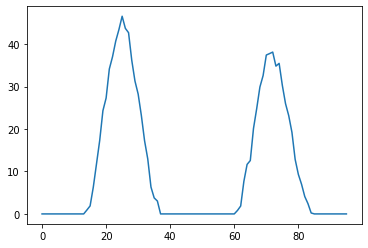

In [23]:
pred = gan.generator(np.expand_dims(tr_sc.transform(test[valid_cols].values[-48*2:]), 0))
pred = pred.numpy()
pred = tar_sc.inverse_transform(pred.reshape(-1, 1)).flatten()
pred = post_processing(pred)
plt.plot(pred)

In [24]:
iteration  = 100
preds = {}
for seed in tqdm(range(iteration)):
    seed_all(seed)

    for i, test_file in enumerate(test_files):
        if seed == 0:
            preds[test_file] = []
            
        test = pd.read_csv(test_file)
        pred = gan.generator(np.expand_dims(tr_sc.transform(test[valid_cols].values[-48*2:]), 0))
        pred = pred.numpy()
        pred = tar_sc.inverse_transform(pred.reshape(-1, 1)).flatten()
        pred = post_processing(pred)
        preds[test_file].append(pred)
        
        if seed == iteration-1:
            preds[test_file] = np.array(preds[test_file])

print('train done')
for key in preds.keys():
    file = key.split('\\')[1]
    idx = sub[sub['id'].map(lambda x: x.split('_')[0]) == file].index
    for i in range(1, 10):
        q = i/10
        sub.loc[idx[0]:idx[-1]][f'q_{q}'] = np.quantile(preds[key], q, axis=0).reshape(-1, 1)

100%|██████████| 100/100 [02:44<00:00,  1.64s/it]


train done


In [25]:
sub.iloc[35:50]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
35,0.csv_Day7_17h30m,0.939822,1.74455,2.099371,2.508042,2.688472,3.140158,3.440304,4.232215,4.806765
36,0.csv_Day7_18h00m,0.000000,0.00000,0.165355,0.428187,0.776151,1.303161,1.609855,1.889655,2.747862
37,0.csv_Day7_18h30m,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.740246
38,0.csv_Day7_19h00m,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
39,0.csv_Day7_19h30m,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
40,0.csv_Day7_20h00m,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
41,0.csv_Day7_20h30m,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
42,0.csv_Day7_21h00m,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
43,0.csv_Day7_21h30m,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
44,0.csv_Day7_22h00m,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [26]:
sub.to_csv('./sub/gan_rnn_100_1229.csv', index=False)